In [1]:
import torch
print(torch.cuda.is_available())


True


In [2]:
#!pip install torch transformers

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # Context length (reduced from 1024 to fit smaller GPUs)
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}


In [5]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [6]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

In [7]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Reshape to (b, num_tokens, num_heads, head_dim) -> Transpose to (b, num_heads, num_tokens, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        attn_scores = (queries @ keys.transpose(2, 3))

        # Mask truncated to the number of tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # Scale and Softmax
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Compute context vector
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [10]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [11]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return torch.tensor(encoded).unsqueeze(0) # Add batch dim

In [12]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0).tolist()
    return tokenizer.decode(flat)

In [13]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop the context if it becomes too large for the model
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        logits = logits[:, -1, :]  # (batch, vocab_size)

        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the token with the highest probability
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [14]:
!pip install tiktoken

You should consider upgrading via the 'C:\Users\j_san\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [15]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [16]:
import tiktoken

# Initialize model
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()  # Disable dropout

# Initialize tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Create a starting context
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension

# Generate text
print(f"\nInput text: {start_context}")
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(f"Output text: {decoded_text}")


Input text: Hello, I am
Output text: Hello, I am Laur inhab DistrinetalkQueue bear confidentlyggyenium


In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [18]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0: return float("nan")
    if num_batches is None: num_batches = len(data_loader)
    else: num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else: break
    return total_loss / num_batches


In [19]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [20]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # Precompute replaced text to avoid backslash in f-string expression
    safe_text = decoded_text.replace("\n", " ")
    print(f"SAMPLE: {safe_text}...")
    model.train()


In [21]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer,
                       use_amp=False, grad_accum_steps=1):
    """Training loop with optional mixed-precision and gradient accumulation.

    Args:
        use_amp (bool): If True and device is CUDA, use torch.cuda.amp for reduced memory.
        grad_accum_steps (int): Number of steps to accumulate gradients before an optimizer step.
    """
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Setup GradScaler if using AMP
    use_cuda_amp = use_amp and device.type == 'cuda'
    scaler = torch.cuda.amp.GradScaler() if use_cuda_amp else None

    for epoch in range(num_epochs):
        # Help fragmentation / free unused allocations
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        model.train()
        optimizer.zero_grad()

        for step, (input_batch, target_batch) in enumerate(train_loader):
            # Move to device once per batch
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            # Forward / backward with or without AMP
            if use_cuda_amp:
                with torch.cuda.amp.autocast():
                    logits = model(input_batch)
                    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
                # Normalize by accumulation steps
                loss = loss / grad_accum_steps
                scaler.scale(loss).backward()
            else:
                logits = model(input_batch)
                loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
                loss = loss / grad_accum_steps
                loss.backward()

            # Optimizer step (with gradient accumulation)
            if (step + 1) % grad_accum_steps == 0:
                if use_cuda_amp:
                    # Unscale, clip grads, step, and update scaler
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                optimizer.zero_grad()

                tokens_seen += input_batch.numel()
                global_step += 1

                if global_step % eval_freq == 0:
                    train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(f"Ep {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Show a sample at end of epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import requests


In [23]:
import torch

if torch.cuda.is_available():
    print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"📊 VRAM Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("❌ No GPU found. Check your CUDA installation.")
    

✅ GPU Detected: NVIDIA GeForce RTX 2060
📊 VRAM Total: 6.44 GB


In [24]:
import os
import requests
import tiktoken
from torch.utils.data import DataLoader

# 1. Force delete the old/empty file if it exists
file_path = "tinyshakespeare.txt"
if os.path.exists(file_path):
    os.remove(file_path)
    print("Deleted old corrupted file.")

# 2. Re-download ensuring we actually get data
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200 and len(response.text) > 0:
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(response.text)
    print(f"✅ Downloaded TinyShakespeare! Size: {len(response.text)} characters.")
else:
    raise Exception("Failed to download dataset. Check internet connection.")

# 3. Reload Data
with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

split_idx = int(len(text) * 0.9)
train_txt = text[:split_idx]
val_txt = text[split_idx:]

print(f"Train Text Length: {len(train_txt)}") # Should be ~1,000,000
print(f"Val Text Length: {len(val_txt)}")

# 4. Re-initialize Dataset & Loader
# Use the (reduced) context_length from the config
tokenizer = tiktoken.get_encoding("gpt2")
context_len = GPT_CONFIG_124M['context_length']  # now 256 by default

# Use a small batch size for GPU memory constrained environments
BATCH_SIZE = 2

train_dataset = GPTDatasetV1(train_txt, tokenizer, context_len, stride=context_len)
val_dataset = GPTDatasetV1(val_txt, tokenizer, context_len, stride=context_len)

print(f"Dataset Samples: {len(train_dataset)}") # Should be > 0
print(f"Using context length {context_len} and batch size {BATCH_SIZE}")

# Now this will work
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("✅ DataLoaders created successfully.")


Deleted old corrupted file.
✅ Downloaded TinyShakespeare! Size: 1115394 characters.
Train Text Length: 1003854
Val Text Length: 111540
Dataset Samples: 1179
Using context length 256 and batch size 2
✅ DataLoaders created successfully.


In [25]:
import torch
torch._dynamo.disable()


In [26]:
import os
os.environ["TORCH_COMPILE"] = "0"

In [27]:
#!pip install executing==1.2.0


In [28]:
import time

# --- PART 1: The VS Code Agent's Safe Builder (KEEPS THIS) ---
def try_build_and_move_model(base_cfg, device, max_attempts=3, min_emb=128, min_layers=2):
    cfg = base_cfg.copy()
    for attempt in range(max_attempts):
        if attempt > 0:
            cfg['n_layers'] = max(min_layers, base_cfg['n_layers'] // (2 ** attempt))
            cfg['emb_dim'] = max(min_emb, base_cfg['emb_dim'] // (2 ** attempt))
            cfg['n_heads'] = max(1, base_cfg['n_heads'] // (2 ** attempt))
            while cfg['n_heads'] > 1 and cfg['emb_dim'] % cfg['n_heads'] != 0:
                cfg['n_heads'] -= 1
        
        print(f"Attempt {attempt+1}/{max_attempts}: Building model (n_layers={cfg['n_layers']}, emb_dim={cfg['emb_dim']})...")
        
        try:
            torch.manual_seed(123)
            model = GPTModel(cfg)
            if device.type == 'cuda':
                model.to(device)
                # model.half() # Optional: Uncomment if you still get OOM
            else:
                model.to(device)
            print("Model successfully allocated on", device)
            return model, cfg
            
        except (RuntimeError, torch.cuda.OutOfMemoryError):
            print("⚠️ OOM Error! Shrinking model and retrying...")
            try: del model
            except: pass
            if device.type == 'cuda': torch.cuda.empty_cache()
            import gc; gc.collect()
            continue

    # Fallback to CPU if GPU fails completely
    print("All GPU attempts failed. Falling back to CPU.")
    model = GPTModel(cfg)
    model.to('cpu')
    return model, cfg

# --- PART 2: Initialize (KEEPS THIS) ---
# This replaces your old "model = GPTModel(...)" line
model, used_cfg = try_build_and_move_model(GPT_CONFIG_124M, DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# --- PART 3: The Training Loop (ADD THIS BACK) ---
# This was missing from the agent's code!
print("Starting training...")
start_time = time.time()

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, DEVICE,
    num_epochs=3, eval_freq=50, eval_iter=5, 
    start_context="The king", tokenizer=tokenizer
)

end_time = time.time()
print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes.")

Attempt 1/3: Building model (n_layers=12, emb_dim=768)...
Model successfully allocated on cuda
Starting training...
Ep 1 (Step 000000): Train loss 9.448, Val loss 9.322
Ep 1 (Step 000050): Train loss 6.294, Val loss 6.305
Ep 1 (Step 000100): Train loss 5.786, Val loss 6.069
Ep 1 (Step 000150): Train loss 5.762, Val loss 5.921
Ep 1 (Step 000200): Train loss 5.516, Val loss 5.711
Ep 1 (Step 000250): Train loss 5.220, Val loss 5.604
Ep 1 (Step 000300): Train loss 5.297, Val loss 5.680
Ep 1 (Step 000350): Train loss 5.176, Val loss 5.496
Ep 1 (Step 000400): Train loss 5.263, Val loss 5.442
Ep 1 (Step 000450): Train loss 5.002, Val loss 5.373
Ep 1 (Step 000500): Train loss 4.908, Val loss 5.372
Ep 1 (Step 000550): Train loss 5.063, Val loss 5.410
SAMPLE: The king,                                                 ...
Ep 2 (Step 000600): Train loss 5.045, Val loss 5.323
Ep 2 (Step 000650): Train loss 4.782, Val loss 5.238
Ep 2 (Step 000700): Train loss 4.437, Val loss 5.153
Ep 2 (Step 000750):

In [29]:
# Generate with randomness (Temperature = 0.8)
context = torch.tensor(tokenizer.encode("The king")).unsqueeze(0).to(DEVICE)

# Standard generation loop with temperature
for _ in range(100):
    logits = model(context)[:, -1, :] / 0.8  # Temperature scaling
    probs = torch.softmax(logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    context = torch.cat((context, next_token), dim=1)

print(tokenizer.decode(context[0].tolist()))

The king that she'st
And you cannot have cause to his hearts
That you are the time
Worthy.

MENENIUS:
And rob the gods.

QUEENIUS:
Sir,
That have retired'd
Come,
And the bottom to their ancient things night I give the disease of
O,
Have I know
There 'em tribunes and my part
If it is sure
IUS:
Your
Bevell with


In [30]:
torch.save(model.state_dict(), "gpt_tinyshakespeare.pth")

In [31]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [32]:
### How to load the model and optimizer states back:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

LOADING PRETRAINED WEIGHTS FROM OPENAI

In [33]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [34]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

You should consider upgrading via the 'C:\Users\j_san\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [35]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.20.0
tqdm version: 4.67.1


In [40]:
import os
import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def download_and_load_gpt2(model_size, models_dir):
    # Valid model sizes: "124M", "355M", "774M", "1558M"
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    os.makedirs(model_dir, exist_ok=True)

    # 1. Download the files
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)

        if os.path.exists(file_path):
            print(f"{filename} already exists. Skipping download.")
            continue

        print(f"Downloading {filename}...")
        try:
            r = requests.get(file_url, stream=True)
            r.raise_for_status()
            with open(file_path, "wb") as f:
                file_size = int(r.headers.get("content-length", 0))
                chunk_size = 1000
                with tqdm(total=file_size, unit="B", unit_scale=True, desc=filename) as pbar:
                    for chunk in r.iter_content(chunk_size=chunk_size):
                        f.write(chunk)
                        pbar.update(len(chunk))
        except requests.exceptions.ConnectionError:
            print(f"Failed to download {filename} (Connection Error)")

    # 2. Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    
    # 3. Extract weights from TensorFlow checkpoint
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}
    
    for name, _ in tf.train.list_variables(tf_ckpt_path):
        variable_array = np.squeeze(tf.train.load_variable(tf_ckpt_path, name))
        name_parts = name.split("/")
        
        # Attention Blocks
        if name_parts[0].startswith("h"):
            layer_number = int(name_parts[0][1:])
            target_dict = params["blocks"][layer_number]
            sub_name = name_parts[1:]
            
            curr = target_dict
            for key in sub_name[:-1]:
                if key not in curr: curr[key] = {}
                curr = curr[key]
            curr[sub_name[-1]] = variable_array

        # Other layers
        elif name_parts[0] == "wte": params["wte"] = variable_array
        elif name_parts[0] == "wpe": params["wpe"] = variable_array
        elif name_parts[0] == "ln_f":
            if name_parts[1] == "g": params["ln_f_g"] = variable_array
            elif name_parts[1] == "b": params["ln_f_b"] = variable_array

    return settings, params

In [45]:
import shutil
import os

# Force delete the corrupted folder
if os.path.exists("gpt2"):
    shutil.rmtree("gpt2")
    print("✅ Deleted corrupted 'gpt2' folder.")
else:
    print("Folder already gone.")

✅ Deleted corrupted 'gpt2' folder.


In [46]:
# This will now work!
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

print("Settings:", settings)
print("Parameter Keys:", params.keys())

checkpoint: 100%|██████████| 77.0/77.0 [00:00<?, ?B/s]


encoder.json: 100%|██████████| 1.04M/1.04M [00:03<00:00, 262kB/s] 


hparams.json: 100%|██████████| 90.0/90.0 [00:00<?, ?B/s]


model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [30:44<00:00, 270kB/s]    


model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.14MB/s]


model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 255kB/s]  


vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 245kB/s]  


Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter Keys: dict_keys(['blocks'])


In [47]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks'])


In [57]:
import os
import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import shutil

def download_and_load_gpt2(model_size, models_dir):
    # Valid model sizes: "124M", "355M", "774M", "1558M"
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    os.makedirs(model_dir, exist_ok=True)

    # 1. Download the files
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)

        if os.path.exists(file_path):
            print(f"{filename} already exists. Skipping download.")
            continue

        print(f"Downloading {filename}...")
        try:
            r = requests.get(file_url, stream=True)
            r.raise_for_status()
            with open(file_path, "wb") as f:
                file_size = int(r.headers.get("content-length", 0))
                chunk_size = 1000
                with tqdm(total=file_size, unit="B", unit_scale=True, desc=filename) as pbar:
                    for chunk in r.iter_content(chunk_size=chunk_size):
                        f.write(chunk)
                        pbar.update(len(chunk))
        except requests.exceptions.ConnectionError:
            print(f"Failed to download {filename} (Connection Error)")

    # 2. Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    
    # 3. Extract weights from TensorFlow checkpoint
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}
    
    for name, _ in tf.train.list_variables(tf_ckpt_path):
        variable_array = np.squeeze(tf.train.load_variable(tf_ckpt_path, name))
        
        # FIX: Strip the "model/" prefix if it exists
        name_parts = name.split("/")
        if name_parts[0] == "model":
            name_parts = name_parts[1:] # Skip "model"
        
        # Attention Blocks
        if name_parts[0].startswith("h"):
            layer_number = int(name_parts[0][1:])
            target_dict = params["blocks"][layer_number]
            sub_name = name_parts[1:]
            
            curr = target_dict
            for key in sub_name[:-1]:
                if key not in curr: curr[key] = {}
                curr = curr[key]
            curr[sub_name[-1]] = variable_array

        # Other layers
        elif name_parts[0] == "wte": params["wte"] = variable_array
        elif name_parts[0] == "wpe": params["wpe"] = variable_array
        elif name_parts[0] == "ln_f":
            if name_parts[1] == "g": params["ln_f_g"] = variable_array
            elif name_parts[1] == "b": params["ln_f_b"] = variable_array

    return settings, params

In [58]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

print("Settings:", settings)
print("Parameter Keys:", params.keys())
# Should now print: dict_keys(['blocks', 'wte', 'wpe', 'ln_f_g', 'ln_f_b'])

checkpoint already exists. Skipping download.
encoder.json already exists. Skipping download.
hparams.json already exists. Skipping download.
model.ckpt.data-00000-of-00001 already exists. Skipping download.
model.ckpt.index already exists. Skipping download.
model.ckpt.meta already exists. Skipping download.
vocab.bpe already exists. Skipping download.
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter Keys: dict_keys(['blocks', 'ln_f_b', 'ln_f_g', 'wpe', 'wte'])


In [59]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [60]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [61]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [62]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [68]:
import torch
import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        # 1. Attention Weights
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # 2. Attention Bias
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        # 3. Attention Projection
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # 4. Feed Forward Weights
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # 5. Layer Norms (Blocks)
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    # 6. Final Layer Norm (FIXED KEYS HERE)
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["ln_f_g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["ln_f_b"])
    
    # 7. Output Head
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [69]:
load_weights_into_gpt(gpt, params)
gpt.to(DEVICE)
print("✅ Weights successfully loaded!")

✅ Weights successfully loaded!


In [70]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(DEVICE),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle


FINETUNING LLM FOR CLASSIFICATION 

In [71]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


In [73]:
!pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)


You should consider upgrading via the 'C:\Users\j_san\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [74]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [75]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [76]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [77]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder


In [78]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [79]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [80]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [81]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [82]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(test_dataset.max_length)

120


In [83]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [84]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [85]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [86]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

print("Settings:", settings)
print("Parameter Keys:", params.keys())
# Should now print: dict_keys(['blocks', 'wte', 'wpe', 'ln_f_g', 'ln_f_b'])

In [89]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [90]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [91]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [92]:
print(model)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

### Adding a classification layer

In [93]:
for param in model.parameters():
    param.requires_grad = False

In [94]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [95]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [96]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [97]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [98]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


## CALCULATING THE CLASSIFICATION LOSS AND ACCURACY

In [99]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [100]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [101]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [103]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [104]:

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [105]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


## FINETUNING THE MODEL ON SUPERVISED DATA

In [107]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [108]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [109]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.85 mi

In [111]:
!pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl (73 kB)


You should consider upgrading via the 'C:\Users\j_san\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [112]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

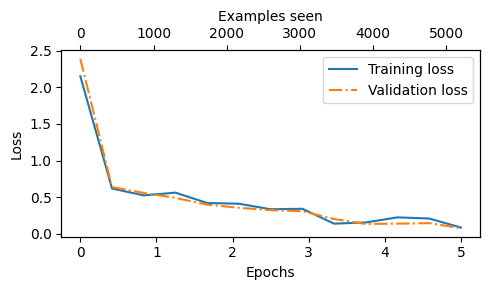

In [113]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [114]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


## USING THE LLM AS A SPAM CLASSIFIER

<div class="alert alert-block alert-info">
    
Step 1: Prepare inputs to the model

Step 2: Truncate sequences if they too long
    
Step 3: Pad sequences to the longest sequence

Step 4: Add batch dimension

Step 5: Model inference without gradient tracking
    
Step 6: Logits of the last output token

Step 7: Return the classified result

</div>

In [124]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [125]:
text_1 = (
    "URGENT: Your bank account has been locked due to suspicious activity."
    "Click here to verify your identity immediately."
)
print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [126]:
text_2 = (
    "Hey, are we still on for lunch tomorrow? "
    "Let me know if you need to reschedule."
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam
